# Mucus Creep

Fit creep compliance of mucus using GM and fractional models.

**Data:** examples/data/creep/biological/creep_mucus_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='\t')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df

def find_examples_data_root():
    """Locate the repo's examples/data directory from any working dir."""
    for base in [Path.cwd(), *Path.cwd().parents]:
        candidate = base / 'examples' / 'data'
        if candidate.exists():
            return candidate
    raise FileNotFoundError('Could not locate examples/data; run from repo root or below.')

import arviz as az


## Load creep compliance data

In [3]:
DATA_DIR = find_examples_data_root() / 'creep' / 'biological'
print(f'Loading data from: {DATA_DIR}')
df = load_tab_file(DATA_DIR / 'creep_mucus_data.csv')
t = df.iloc[:,0].to_numpy()
J = df.iloc[:,1].to_numpy()
print(df.head())


Loading data from: /Users/b80985/Projects/rheojax/examples/data/creep/biological
   Time  Creep Compliance
0   0.5          0.983780
1   1.0          1.480515
2   1.5          1.678908
3   2.0          1.812351
4   2.5          1.883760


## Fit creep models (GM vs fractional)

In [4]:
gm = GeneralizedMaxwell(n_modes=4, modulus_type='tensile')
gm.fit(t, J, test_mode='creep', use_log_residuals=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, J)

fm = FractionalMaxwellModel()
fm.fit(t, J, test_mode='creep', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='creep')
fm_r2 = r2_complex(J, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.255554s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=27 | final_cost=7.5079e-04 | elapsed=3.256s | final_gradient_norm=0.0025


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.524637s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=27 | final_cost=7.5079e-04 | elapsed=0.525s | final_gradient_norm=0.0025


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.685436s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=31 | final_cost=7.5076e-04 | elapsed=1.685s | final_gradient_norm=0.0032


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.391634s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=37 | final_cost=7.5072e-04 | elapsed=1.392s | final_gradient_norm=0.0174


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.033833s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.0053 | elapsed=1.034s | final_gradient_norm=1.1039e-05


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.548741s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=3.8673e+04 | elapsed=1.549s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


{'gm_r2': 0.9993441922159179, 'fm_r2': -185042.64895731225}


## Plot creep fits

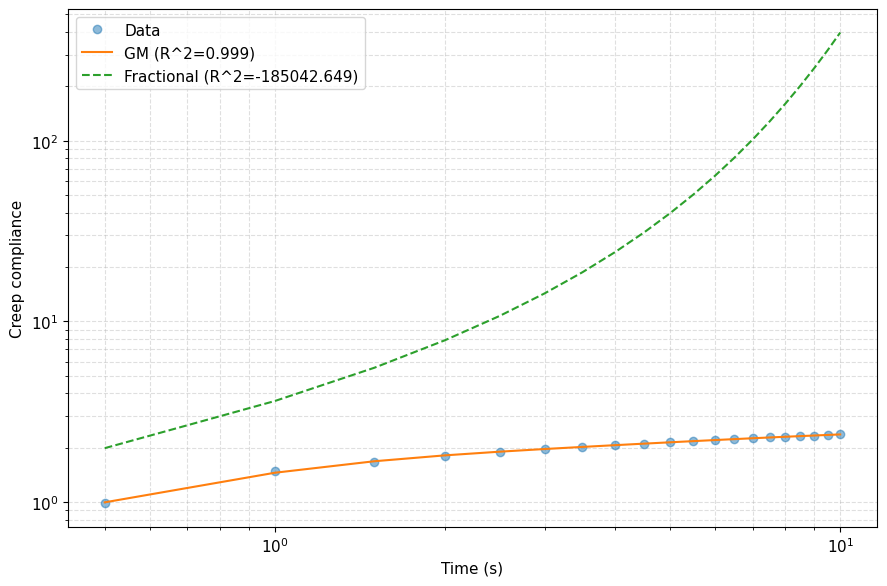

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, J, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Creep compliance')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.338819s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=21 | final_cost=7.5072e-04 | elapsed=0.339s | final_gradient_norm=0.0183


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.423586s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=21 | final_cost=7.5072e-04 | elapsed=0.424s | final_gradient_norm=0.0183


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.390469s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.0053 | elapsed=0.390s | final_gradient_norm=1.1039e-05


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.970312s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=3.8673e+04 | elapsed=0.970s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


Dataset 0 ranking: [('fm', -32.756)]


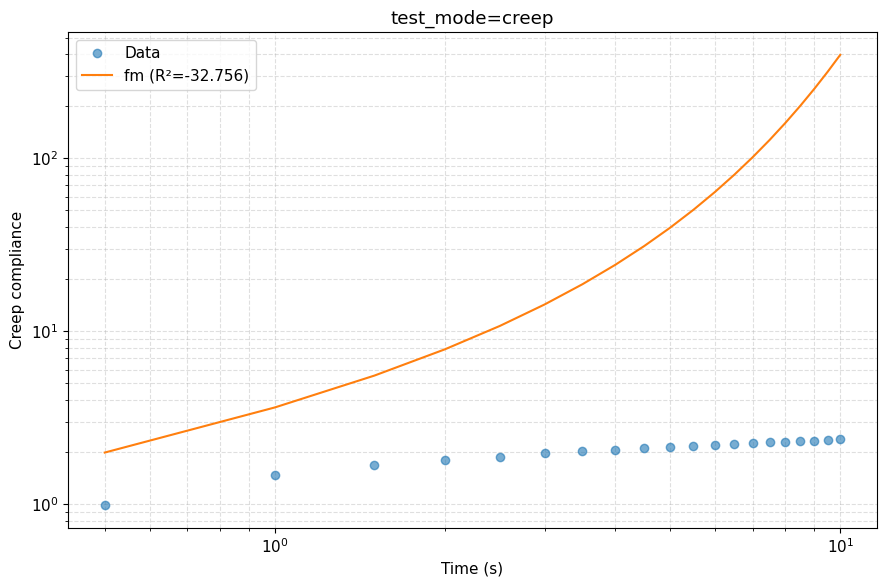

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<07:15,  1.61it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 13/700 [00:00<00:30, 22.58it/s, 15 steps of size 2.34e-06. acc. prob=0.62]

warmup:   3%|▎         | 23/700 [00:00<00:18, 37.08it/s, 14 steps of size 7.74e-06. acc. prob=0.78]

warmup:   5%|▌         | 38/700 [00:00<00:10, 61.62it/s, 3 steps of size 2.48e-05. acc. prob=0.86] 

warmup:   7%|▋         | 49/700 [00:01<00:09, 69.85it/s, 3 steps of size 8.77e-07. acc. prob=0.85]

warmup:   8%|▊         | 59/700 [00:01<00:09, 66.68it/s, 15 steps of size 9.75e-08. acc. prob=0.85]

warmup:  10%|▉         | 68/700 [00:01<00:09, 65.35it/s, 4 steps of size 2.58e-08. acc. prob=0.85] 

warmup:  11%|█         | 76/700 [00:01<00:14, 41.95it/s, 16 steps of size 1.16e-08. acc. prob=0.86]

warmup:  12%|█▏        | 82/700 [00:02<00:24, 24.98it/s, 20 steps of size 1.77e-08. acc. prob=0.87]

warmup:  12%|█▏        | 87/700 [00:02<00:27, 22.55it/s, 51 steps of size 2.48e-08. acc. prob=0.87]

warmup:  13%|█▎        | 91/700 [00:02<00:25, 24.10it/s, 9 steps of size 1.47e-08. acc. prob=0.87] 

warmup:  14%|█▎        | 96/700 [00:02<00:22, 27.28it/s, 6 steps of size 1.07e-08. acc. prob=0.87]

warmup:  14%|█▍        | 100/700 [00:03<00:36, 16.48it/s, 112 steps of size 1.21e-08. acc. prob=0.88]

warmup:  15%|█▍        | 103/700 [00:10<04:56,  2.01it/s, 511 steps of size 1.30e-07. acc. prob=0.88]

warmup:  15%|█▌        | 106/700 [00:13<06:24,  1.54it/s, 415 steps of size 1.42e-07. acc. prob=0.88]

warmup:  15%|█▌        | 108/700 [00:17<08:37,  1.14it/s, 845 steps of size 1.51e-07. acc. prob=0.89]

warmup:  16%|█▌        | 110/700 [00:19<08:24,  1.17it/s, 387 steps of size 1.59e-07. acc. prob=0.89]

warmup:  16%|█▌        | 111/700 [00:20<08:34,  1.14it/s, 511 steps of size 1.64e-07. acc. prob=0.89]

warmup:  16%|█▌        | 112/700 [00:20<08:05,  1.21it/s, 318 steps of size 1.67e-07. acc. prob=0.89]

warmup:  16%|█▌        | 113/700 [00:21<08:14,  1.19it/s, 477 steps of size 1.71e-07. acc. prob=0.89]

warmup:  16%|█▋        | 114/700 [00:21<06:46,  1.44it/s, 114 steps of size 1.71e-07. acc. prob=0.89]

warmup:  16%|█▋        | 115/700 [00:22<06:25,  1.52it/s, 338 steps of size 1.75e-07. acc. prob=0.89]

warmup:  17%|█▋        | 116/700 [00:22<05:21,  1.81it/s, 205 steps of size 1.77e-07. acc. prob=0.89]

warmup:  17%|█▋        | 117/700 [00:23<05:34,  1.74it/s, 408 steps of size 1.81e-07. acc. prob=0.89]

warmup:  17%|█▋        | 118/700 [00:23<05:12,  1.86it/s, 314 steps of size 1.84e-07. acc. prob=0.90]

warmup:  17%|█▋        | 119/700 [00:24<05:58,  1.62it/s, 511 steps of size 1.89e-07. acc. prob=0.90]

warmup:  17%|█▋        | 120/700 [00:24<05:05,  1.90it/s, 255 steps of size 1.94e-07. acc. prob=0.90]

warmup:  17%|█▋        | 122/700 [00:25<03:16,  2.94it/s, 124 steps of size 1.94e-07. acc. prob=0.90]

warmup:  18%|█▊        | 123/700 [00:25<03:15,  2.94it/s, 293 steps of size 1.97e-07. acc. prob=0.90]

warmup:  18%|█▊        | 124/700 [00:25<02:54,  3.30it/s, 197 steps of size 1.99e-07. acc. prob=0.90]

warmup:  18%|█▊        | 125/700 [00:26<03:08,  3.05it/s, 314 steps of size 2.02e-07. acc. prob=0.90]

warmup:  18%|█▊        | 127/700 [00:26<02:25,  3.94it/s, 216 steps of size 2.03e-07. acc. prob=0.90]

warmup:  18%|█▊        | 128/700 [00:26<02:36,  3.66it/s, 302 steps of size 2.05e-07. acc. prob=0.90]

warmup:  18%|█▊        | 129/700 [00:26<02:37,  3.62it/s, 290 steps of size 2.08e-07. acc. prob=0.90]

warmup:  19%|█▊        | 130/700 [00:27<02:25,  3.91it/s, 192 steps of size 2.10e-07. acc. prob=0.90]

warmup:  19%|█▊        | 131/700 [00:27<02:16,  4.16it/s, 239 steps of size 2.12e-07. acc. prob=0.91]

warmup:  19%|█▉        | 132/700 [00:27<02:34,  3.69it/s, 346 steps of size 2.16e-07. acc. prob=0.91]

warmup:  19%|█▉        | 133/700 [00:27<02:13,  4.23it/s, 160 steps of size 2.17e-07. acc. prob=0.91]

warmup:  19%|█▉        | 134/700 [00:28<01:53,  4.99it/s, 119 steps of size 2.17e-07. acc. prob=0.91]

warmup:  19%|█▉        | 135/700 [00:28<02:15,  4.17it/s, 214 steps of size 2.19e-07. acc. prob=0.91]

warmup:  20%|█▉        | 137/700 [00:28<02:08,  4.37it/s, 307 steps of size 2.21e-07. acc. prob=0.91]

warmup:  20%|█▉        | 138/700 [00:29<04:21,  2.15it/s, 392 steps of size 2.24e-07. acc. prob=0.91]

warmup:  20%|█▉        | 139/700 [00:31<06:09,  1.52it/s, 383 steps of size 2.27e-07. acc. prob=0.91]

warmup:  20%|██        | 140/700 [00:31<05:46,  1.62it/s, 248 steps of size 2.30e-07. acc. prob=0.91]

warmup:  20%|██        | 141/700 [00:32<06:36,  1.41it/s, 480 steps of size 2.33e-07. acc. prob=0.91]

warmup:  20%|██        | 142/700 [00:32<05:20,  1.74it/s, 159 steps of size 2.34e-07. acc. prob=0.91]

warmup:  20%|██        | 143/700 [00:33<06:15,  1.48it/s, 511 steps of size 2.39e-07. acc. prob=0.91]

warmup:  21%|██        | 144/700 [00:34<06:34,  1.41it/s, 498 steps of size 2.42e-07. acc. prob=0.91]

warmup:  21%|██        | 145/700 [00:35<05:55,  1.56it/s, 318 steps of size 2.45e-07. acc. prob=0.91]

warmup:  21%|██        | 146/700 [00:35<05:10,  1.79it/s, 241 steps of size 2.48e-07. acc. prob=0.91]

warmup:  21%|██        | 147/700 [00:35<03:54,  2.36it/s, 120 steps of size 2.47e-07. acc. prob=0.92]

warmup:  21%|██        | 148/700 [00:35<03:05,  2.97it/s, 118 steps of size 2.47e-07. acc. prob=0.92]

warmup:  21%|██▏       | 149/700 [00:36<03:31,  2.60it/s, 284 steps of size 2.50e-07. acc. prob=0.92]

warmup:  22%|██▏       | 151/700 [00:36<02:09,  4.23it/s, 60 steps of size 2.43e-06. acc. prob=0.92] 

warmup:  22%|██▏       | 157/700 [00:36<00:52, 10.27it/s, 83 steps of size 8.26e-07. acc. prob=0.92]

warmup:  23%|██▎       | 159/700 [00:36<00:53, 10.13it/s, 72 steps of size 7.98e-07. acc. prob=0.92]

warmup:  23%|██▎       | 161/700 [00:36<00:54,  9.95it/s, 28 steps of size 7.42e-07. acc. prob=0.92]

warmup:  23%|██▎       | 163/700 [00:37<01:03,  8.48it/s, 127 steps of size 7.79e-07. acc. prob=0.92]

warmup:  24%|██▎       | 165/700 [00:37<00:56,  9.45it/s, 38 steps of size 7.74e-07. acc. prob=0.92] 

warmup:  24%|██▍       | 168/700 [00:37<00:45, 11.74it/s, 66 steps of size 6.69e-07. acc. prob=0.92]

warmup:  24%|██▍       | 170/700 [00:37<00:47, 11.23it/s, 87 steps of size 6.63e-07. acc. prob=0.92]

warmup:  25%|██▍       | 173/700 [00:37<00:38, 13.74it/s, 47 steps of size 6.03e-07. acc. prob=0.92]

warmup:  25%|██▌       | 175/700 [00:38<00:51, 10.19it/s, 127 steps of size 6.54e-07. acc. prob=0.92]

warmup:  25%|██▌       | 178/700 [00:38<00:45, 11.46it/s, 63 steps of size 6.63e-07. acc. prob=0.93] 

warmup:  26%|██▌       | 180/700 [00:38<00:53,  9.79it/s, 99 steps of size 6.82e-07. acc. prob=0.93]

warmup:  26%|██▌       | 182/700 [00:38<00:54,  9.59it/s, 100 steps of size 6.99e-07. acc. prob=0.93]

warmup:  26%|██▋       | 184/700 [00:39<00:52,  9.82it/s, 92 steps of size 7.05e-07. acc. prob=0.93] 

warmup:  27%|██▋       | 186/700 [00:39<00:48, 10.61it/s, 76 steps of size 7.08e-07. acc. prob=0.93]

warmup:  27%|██▋       | 188/700 [00:39<00:59,  8.64it/s, 91 steps of size 7.19e-07. acc. prob=0.93]

warmup:  27%|██▋       | 190/700 [00:39<00:49, 10.33it/s, 80 steps of size 6.99e-07. acc. prob=0.93]

warmup:  27%|██▋       | 192/700 [00:40<01:04,  7.93it/s, 127 steps of size 7.48e-07. acc. prob=0.93]

warmup:  28%|██▊       | 194/700 [00:40<01:49,  4.61it/s, 127 steps of size 7.99e-07. acc. prob=0.93]

warmup:  28%|██▊       | 195/700 [00:41<02:01,  4.15it/s, 127 steps of size 8.26e-07. acc. prob=0.93]

warmup:  28%|██▊       | 196/700 [00:41<01:52,  4.47it/s, 110 steps of size 8.34e-07. acc. prob=0.93]

warmup:  28%|██▊       | 198/700 [00:41<01:39,  5.04it/s, 127 steps of size 8.71e-07. acc. prob=0.93]

warmup:  29%|██▊       | 200/700 [00:42<01:40,  4.95it/s, 223 steps of size 7.52e-07. acc. prob=0.93]

sample:  29%|██▊       | 201/700 [00:42<01:57,  4.25it/s, 208 steps of size 7.52e-07. acc. prob=1.00]

sample:  29%|██▉       | 202/700 [00:42<02:14,  3.70it/s, 248 steps of size 7.52e-07. acc. prob=1.00]

sample:  29%|██▉       | 203/700 [00:43<02:36,  3.18it/s, 255 steps of size 7.52e-07. acc. prob=1.00]

sample:  29%|██▉       | 204/700 [00:43<02:15,  3.67it/s, 127 steps of size 7.52e-07. acc. prob=1.00]

sample:  29%|██▉       | 205/700 [00:44<02:42,  3.04it/s, 255 steps of size 7.52e-07. acc. prob=1.00]

sample:  29%|██▉       | 206/700 [00:44<02:24,  3.41it/s, 146 steps of size 7.52e-07. acc. prob=1.00]

sample:  30%|██▉       | 207/700 [00:44<03:09,  2.60it/s, 296 steps of size 7.52e-07. acc. prob=1.00]

sample:  30%|██▉       | 208/700 [00:44<02:30,  3.27it/s, 108 steps of size 7.52e-07. acc. prob=1.00]

sample:  30%|███       | 210/700 [00:45<01:59,  4.11it/s, 203 steps of size 7.52e-07. acc. prob=1.00]

sample:  30%|███       | 211/700 [00:45<01:50,  4.42it/s, 99 steps of size 7.52e-07. acc. prob=0.99] 

sample:  30%|███       | 213/700 [00:45<01:27,  5.55it/s, 108 steps of size 7.52e-07. acc. prob=0.99]

sample:  31%|███       | 215/700 [00:45<01:09,  6.98it/s, 98 steps of size 7.52e-07. acc. prob=0.99] 

sample:  31%|███       | 216/700 [00:46<01:14,  6.49it/s, 154 steps of size 7.52e-07. acc. prob=0.99]

sample:  31%|███       | 217/700 [00:46<01:47,  4.51it/s, 228 steps of size 7.52e-07. acc. prob=0.99]

sample:  31%|███       | 218/700 [00:46<01:35,  5.03it/s, 127 steps of size 7.52e-07. acc. prob=0.99]

sample:  31%|███▏      | 220/700 [00:46<01:11,  6.73it/s, 82 steps of size 7.52e-07. acc. prob=0.99] 

sample:  32%|███▏      | 223/700 [00:47<01:02,  7.62it/s, 144 steps of size 7.52e-07. acc. prob=0.99]

sample:  32%|███▏      | 224/700 [00:47<01:01,  7.76it/s, 117 steps of size 7.52e-07. acc. prob=0.99]

sample:  32%|███▏      | 225/700 [00:47<01:03,  7.46it/s, 104 steps of size 7.52e-07. acc. prob=0.99]

sample:  32%|███▏      | 226/700 [00:47<01:08,  6.96it/s, 147 steps of size 7.52e-07. acc. prob=0.99]

sample:  33%|███▎      | 229/700 [00:47<00:44, 10.59it/s, 37 steps of size 7.52e-07. acc. prob=0.99] 

sample:  33%|███▎      | 231/700 [00:47<00:41, 11.36it/s, 83 steps of size 7.52e-07. acc. prob=0.99]

sample:  33%|███▎      | 233/700 [00:48<00:45, 10.25it/s, 127 steps of size 7.52e-07. acc. prob=0.99]

sample:  34%|███▎      | 235/700 [00:48<00:48,  9.68it/s, 85 steps of size 7.52e-07. acc. prob=0.99] 

sample:  34%|███▍      | 237/700 [00:48<00:42, 10.84it/s, 45 steps of size 7.52e-07. acc. prob=0.99]

sample:  34%|███▍      | 239/700 [00:48<00:41, 11.16it/s, 65 steps of size 7.52e-07. acc. prob=0.99]

sample:  35%|███▍      | 243/700 [00:48<00:31, 14.73it/s, 53 steps of size 7.52e-07. acc. prob=0.99]

sample:  35%|███▌      | 245/700 [00:48<00:29, 15.60it/s, 28 steps of size 7.52e-07. acc. prob=0.99]

sample:  36%|███▌      | 251/700 [00:49<00:19, 23.14it/s, 71 steps of size 7.52e-07. acc. prob=0.97]

sample:  36%|███▋      | 254/700 [00:49<00:20, 21.67it/s, 26 steps of size 7.52e-07. acc. prob=0.98]

sample:  37%|███▋      | 257/700 [00:49<00:19, 23.26it/s, 9 steps of size 7.52e-07. acc. prob=0.97] 

sample:  37%|███▋      | 261/700 [00:49<00:19, 22.99it/s, 85 steps of size 7.52e-07. acc. prob=0.97]

sample:  38%|███▊      | 264/700 [00:49<00:19, 22.59it/s, 28 steps of size 7.52e-07. acc. prob=0.97]

sample:  38%|███▊      | 267/700 [00:50<00:32, 13.50it/s, 127 steps of size 7.52e-07. acc. prob=0.97]

sample:  38%|███▊      | 269/700 [00:50<00:32, 13.12it/s, 127 steps of size 7.52e-07. acc. prob=0.97]

sample:  39%|███▊      | 271/700 [00:50<00:50,  8.47it/s, 245 steps of size 7.52e-07. acc. prob=0.97]

sample:  39%|███▉      | 273/700 [00:50<00:51,  8.36it/s, 121 steps of size 7.52e-07. acc. prob=0.97]

sample:  39%|███▉      | 275/700 [00:51<00:50,  8.37it/s, 127 steps of size 7.52e-07. acc. prob=0.98]

sample:  40%|███▉      | 277/700 [00:51<00:59,  7.05it/s, 211 steps of size 7.52e-07. acc. prob=0.98]

sample:  40%|███▉      | 278/700 [00:51<00:58,  7.25it/s, 127 steps of size 7.52e-07. acc. prob=0.98]

sample:  40%|███▉      | 279/700 [00:51<00:59,  7.10it/s, 134 steps of size 7.52e-07. acc. prob=0.98]

sample:  40%|████      | 280/700 [00:52<00:58,  7.23it/s, 126 steps of size 7.52e-07. acc. prob=0.98]

sample:  40%|████      | 281/700 [00:52<01:04,  6.53it/s, 171 steps of size 7.52e-07. acc. prob=0.98]

sample:  40%|████      | 282/700 [00:52<01:06,  6.29it/s, 126 steps of size 7.52e-07. acc. prob=0.98]

sample:  40%|████      | 283/700 [00:52<01:11,  5.81it/s, 127 steps of size 7.52e-07. acc. prob=0.98]

sample:  41%|████      | 284/700 [00:52<01:26,  4.79it/s, 200 steps of size 7.52e-07. acc. prob=0.98]

sample:  41%|████      | 285/700 [00:53<01:14,  5.55it/s, 114 steps of size 7.52e-07. acc. prob=0.98]

sample:  41%|████      | 287/700 [00:53<01:00,  6.80it/s, 123 steps of size 7.52e-07. acc. prob=0.98]

sample:  41%|████      | 288/700 [00:53<01:00,  6.82it/s, 99 steps of size 7.52e-07. acc. prob=0.98] 

sample:  41%|████▏     | 290/700 [00:53<00:47,  8.63it/s, 62 steps of size 7.52e-07. acc. prob=0.98]

sample:  42%|████▏     | 291/700 [00:53<01:08,  5.95it/s, 103 steps of size 7.52e-07. acc. prob=0.98]

sample:  42%|████▏     | 293/700 [00:54<00:52,  7.69it/s, 51 steps of size 7.52e-07. acc. prob=0.98] 

sample:  42%|████▏     | 295/700 [00:54<00:42,  9.61it/s, 66 steps of size 7.52e-07. acc. prob=0.98]

sample:  42%|████▏     | 297/700 [00:54<00:53,  7.53it/s, 87 steps of size 7.52e-07. acc. prob=0.98]

sample:  43%|████▎     | 298/700 [00:54<01:00,  6.66it/s, 160 steps of size 7.52e-07. acc. prob=0.98]

sample:  43%|████▎     | 301/700 [00:54<00:42,  9.46it/s, 96 steps of size 7.52e-07. acc. prob=0.98] 

sample:  43%|████▎     | 303/700 [00:55<00:48,  8.14it/s, 127 steps of size 7.52e-07. acc. prob=0.98]

sample:  43%|████▎     | 304/700 [00:55<00:54,  7.27it/s, 127 steps of size 7.52e-07. acc. prob=0.98]

sample:  44%|████▎     | 305/700 [00:55<00:56,  6.97it/s, 119 steps of size 7.52e-07. acc. prob=0.98]

sample:  44%|████▎     | 306/700 [00:55<01:01,  6.41it/s, 127 steps of size 7.52e-07. acc. prob=0.98]

sample:  44%|████▍     | 307/700 [00:55<00:56,  7.01it/s, 117 steps of size 7.52e-07. acc. prob=0.98]

sample:  44%|████▍     | 308/700 [00:56<00:58,  6.72it/s, 127 steps of size 7.52e-07. acc. prob=0.98]

sample:  44%|████▍     | 309/700 [00:56<00:53,  7.32it/s, 127 steps of size 7.52e-07. acc. prob=0.98]

sample:  44%|████▍     | 310/700 [00:56<00:57,  6.79it/s, 144 steps of size 7.52e-07. acc. prob=0.98]

sample:  44%|████▍     | 311/700 [00:56<01:01,  6.32it/s, 127 steps of size 7.52e-07. acc. prob=0.98]

sample:  45%|████▍     | 313/700 [00:56<00:43,  8.91it/s, 66 steps of size 7.52e-07. acc. prob=0.98] 

sample:  45%|████▌     | 315/700 [00:56<00:48,  7.96it/s, 103 steps of size 7.52e-07. acc. prob=0.98]

sample:  45%|████▌     | 317/700 [00:57<00:42,  8.93it/s, 114 steps of size 7.52e-07. acc. prob=0.98]

sample:  45%|████▌     | 318/700 [00:57<00:42,  8.96it/s, 127 steps of size 7.52e-07. acc. prob=0.98]

sample:  46%|████▌     | 319/700 [00:57<00:42,  9.03it/s, 127 steps of size 7.52e-07. acc. prob=0.98]

sample:  46%|████▌     | 321/700 [00:57<00:36, 10.27it/s, 81 steps of size 7.52e-07. acc. prob=0.98] 

sample:  46%|████▋     | 324/700 [00:57<00:26, 13.97it/s, 28 steps of size 7.52e-07. acc. prob=0.98]

sample:  47%|████▋     | 326/700 [00:57<00:33, 11.08it/s, 55 steps of size 7.52e-07. acc. prob=0.98]

sample:  47%|████▋     | 328/700 [00:57<00:31, 11.91it/s, 56 steps of size 7.52e-07. acc. prob=0.98]

sample:  47%|████▋     | 332/700 [00:58<00:21, 17.23it/s, 16 steps of size 7.52e-07. acc. prob=0.98]

sample:  49%|████▉     | 342/700 [00:58<00:10, 34.29it/s, 8 steps of size 7.52e-07. acc. prob=0.96] 

sample:  49%|████▉     | 346/700 [00:58<00:11, 30.70it/s, 52 steps of size 7.52e-07. acc. prob=0.96]

sample:  50%|█████     | 350/700 [00:58<00:13, 26.66it/s, 33 steps of size 7.52e-07. acc. prob=0.96]

sample:  51%|█████     | 354/700 [00:59<00:19, 17.48it/s, 158 steps of size 7.52e-07. acc. prob=0.96]

sample:  51%|█████     | 357/700 [00:59<00:40,  8.46it/s, 164 steps of size 7.52e-07. acc. prob=0.96]

sample:  51%|█████▏    | 359/700 [01:00<00:48,  6.98it/s, 83 steps of size 7.52e-07. acc. prob=0.96] 

sample:  52%|█████▏    | 361/700 [01:00<00:48,  6.98it/s, 115 steps of size 7.52e-07. acc. prob=0.96]

sample:  52%|█████▏    | 363/700 [01:01<00:46,  7.21it/s, 50 steps of size 7.52e-07. acc. prob=0.96] 

sample:  52%|█████▏    | 365/700 [01:01<01:00,  5.51it/s, 161 steps of size 7.52e-07. acc. prob=0.96]

sample:  52%|█████▏    | 366/700 [01:01<01:04,  5.16it/s, 202 steps of size 7.52e-07. acc. prob=0.96]

sample:  53%|█████▎    | 368/700 [01:02<00:54,  6.06it/s, 105 steps of size 7.52e-07. acc. prob=0.96]

sample:  53%|█████▎    | 369/700 [01:02<01:01,  5.38it/s, 189 steps of size 7.52e-07. acc. prob=0.96]

sample:  53%|█████▎    | 370/700 [01:02<01:05,  5.04it/s, 189 steps of size 7.52e-07. acc. prob=0.96]

sample:  53%|█████▎    | 371/700 [01:02<00:58,  5.59it/s, 127 steps of size 7.52e-07. acc. prob=0.96]

sample:  53%|█████▎    | 372/700 [01:02<01:01,  5.38it/s, 174 steps of size 7.52e-07. acc. prob=0.96]

sample:  53%|█████▎    | 374/700 [01:03<01:02,  5.20it/s, 235 steps of size 7.52e-07. acc. prob=0.96]

sample:  54%|█████▎    | 376/700 [01:03<00:46,  7.01it/s, 67 steps of size 7.52e-07. acc. prob=0.96] 

sample:  54%|█████▍    | 378/700 [01:03<00:40,  7.97it/s, 127 steps of size 7.52e-07. acc. prob=0.96]

sample:  54%|█████▍    | 379/700 [01:03<00:41,  7.77it/s, 127 steps of size 7.52e-07. acc. prob=0.96]

sample:  54%|█████▍    | 380/700 [01:03<00:41,  7.71it/s, 150 steps of size 7.52e-07. acc. prob=0.96]

sample:  54%|█████▍    | 381/700 [01:04<00:47,  6.78it/s, 192 steps of size 7.52e-07. acc. prob=0.96]

sample:  55%|█████▍    | 382/700 [01:04<00:52,  6.01it/s, 196 steps of size 7.52e-07. acc. prob=0.96]

sample:  55%|█████▍    | 383/700 [01:04<01:05,  4.81it/s, 255 steps of size 7.52e-07. acc. prob=0.97]

sample:  55%|█████▍    | 384/700 [01:04<01:02,  5.09it/s, 143 steps of size 7.52e-07. acc. prob=0.97]

sample:  55%|█████▌    | 385/700 [01:04<00:54,  5.73it/s, 127 steps of size 7.52e-07. acc. prob=0.97]

sample:  55%|█████▌    | 386/700 [01:05<00:49,  6.34it/s, 127 steps of size 7.52e-07. acc. prob=0.97]

sample:  55%|█████▌    | 388/700 [01:05<00:43,  7.22it/s, 140 steps of size 7.52e-07. acc. prob=0.97]

sample:  56%|█████▌    | 390/700 [01:05<00:37,  8.21it/s, 94 steps of size 7.52e-07. acc. prob=0.97] 

sample:  56%|█████▌    | 392/700 [01:05<00:31,  9.80it/s, 86 steps of size 7.52e-07. acc. prob=0.97]

sample:  56%|█████▋    | 395/700 [01:05<00:23, 12.72it/s, 21 steps of size 7.52e-07. acc. prob=0.97]

sample:  57%|█████▋    | 397/700 [01:05<00:21, 14.04it/s, 30 steps of size 7.52e-07. acc. prob=0.97]

sample:  57%|█████▋    | 399/700 [01:06<00:20, 14.94it/s, 69 steps of size 7.52e-07. acc. prob=0.97]

sample:  57%|█████▋    | 401/700 [01:06<00:20, 14.94it/s, 63 steps of size 7.52e-07. acc. prob=0.97]

sample:  58%|█████▊    | 403/700 [01:06<00:20, 14.33it/s, 55 steps of size 7.52e-07. acc. prob=0.97]

sample:  58%|█████▊    | 405/700 [01:06<00:21, 13.93it/s, 62 steps of size 7.52e-07. acc. prob=0.97]

sample:  58%|█████▊    | 407/700 [01:06<00:20, 14.00it/s, 125 steps of size 7.52e-07. acc. prob=0.97]

sample:  58%|█████▊    | 409/700 [01:06<00:20, 14.40it/s, 85 steps of size 7.52e-07. acc. prob=0.97] 

sample:  59%|█████▊    | 411/700 [01:06<00:19, 15.15it/s, 24 steps of size 7.52e-07. acc. prob=0.97]

sample:  59%|█████▉    | 413/700 [01:06<00:17, 16.26it/s, 53 steps of size 7.52e-07. acc. prob=0.97]

sample:  59%|█████▉    | 416/700 [01:07<00:16, 17.70it/s, 21 steps of size 7.52e-07. acc. prob=0.97]

sample:  60%|█████▉    | 418/700 [01:07<00:20, 13.97it/s, 61 steps of size 7.52e-07. acc. prob=0.97]

sample:  60%|██████    | 420/700 [01:07<00:18, 15.13it/s, 53 steps of size 7.52e-07. acc. prob=0.97]

sample:  60%|██████    | 422/700 [01:07<00:19, 14.14it/s, 63 steps of size 7.52e-07. acc. prob=0.97]

sample:  61%|██████    | 424/700 [01:07<00:23, 11.62it/s, 127 steps of size 7.52e-07. acc. prob=0.97]

sample:  61%|██████    | 426/700 [01:08<00:24, 11.29it/s, 86 steps of size 7.52e-07. acc. prob=0.97] 

sample:  61%|██████▏   | 429/700 [01:08<00:19, 13.78it/s, 63 steps of size 7.52e-07. acc. prob=0.97]

sample:  62%|██████▏   | 432/700 [01:08<00:16, 16.67it/s, 60 steps of size 7.52e-07. acc. prob=0.97]

sample:  62%|██████▏   | 434/700 [01:08<00:18, 14.32it/s, 91 steps of size 7.52e-07. acc. prob=0.97]

sample:  62%|██████▏   | 436/700 [01:08<00:26,  9.83it/s, 200 steps of size 7.52e-07. acc. prob=0.97]

sample:  63%|██████▎   | 438/700 [01:08<00:24, 10.74it/s, 63 steps of size 7.52e-07. acc. prob=0.97] 

sample:  63%|██████▎   | 440/700 [01:09<00:24, 10.44it/s, 127 steps of size 7.52e-07. acc. prob=0.97]

sample:  63%|██████▎   | 442/700 [01:09<00:26,  9.78it/s, 99 steps of size 7.52e-07. acc. prob=0.97] 

sample:  63%|██████▎   | 444/700 [01:09<00:23, 11.08it/s, 82 steps of size 7.52e-07. acc. prob=0.97]

sample:  64%|██████▎   | 446/700 [01:09<00:28,  8.99it/s, 127 steps of size 7.52e-07. acc. prob=0.97]

sample:  64%|██████▍   | 448/700 [01:10<00:27,  9.04it/s, 127 steps of size 7.52e-07. acc. prob=0.97]

sample:  64%|██████▍   | 451/700 [01:10<00:22, 11.14it/s, 76 steps of size 7.52e-07. acc. prob=0.97] 

sample:  65%|██████▍   | 454/700 [01:10<00:17, 14.21it/s, 48 steps of size 7.52e-07. acc. prob=0.97]

sample:  65%|██████▌   | 456/700 [01:10<00:15, 15.26it/s, 29 steps of size 7.52e-07. acc. prob=0.97]

sample:  66%|██████▌   | 459/700 [01:10<00:14, 16.81it/s, 63 steps of size 7.52e-07. acc. prob=0.97]

sample:  66%|██████▌   | 461/700 [01:10<00:13, 17.14it/s, 86 steps of size 7.52e-07. acc. prob=0.97]

sample:  66%|██████▌   | 463/700 [01:10<00:13, 17.04it/s, 69 steps of size 7.52e-07. acc. prob=0.97]

sample:  66%|██████▋   | 465/700 [01:11<00:17, 13.77it/s, 146 steps of size 7.52e-07. acc. prob=0.97]

sample:  67%|██████▋   | 467/700 [01:11<00:21, 10.90it/s, 169 steps of size 7.52e-07. acc. prob=0.97]

sample:  67%|██████▋   | 469/700 [01:11<00:23,  9.68it/s, 135 steps of size 7.52e-07. acc. prob=0.97]

sample:  67%|██████▋   | 471/700 [01:11<00:21, 10.86it/s, 56 steps of size 7.52e-07. acc. prob=0.97] 

sample:  68%|██████▊   | 473/700 [01:11<00:19, 11.56it/s, 65 steps of size 7.52e-07. acc. prob=0.97]

sample:  68%|██████▊   | 475/700 [01:12<00:18, 12.44it/s, 90 steps of size 7.52e-07. acc. prob=0.97]

sample:  68%|██████▊   | 477/700 [01:12<00:22,  9.90it/s, 183 steps of size 7.52e-07. acc. prob=0.97]

sample:  68%|██████▊   | 479/700 [01:12<00:25,  8.82it/s, 255 steps of size 7.52e-07. acc. prob=0.97]

sample:  69%|██████▊   | 481/700 [01:12<00:28,  7.67it/s, 169 steps of size 7.52e-07. acc. prob=0.97]

sample:  69%|██████▉   | 482/700 [01:13<00:32,  6.72it/s, 255 steps of size 7.52e-07. acc. prob=0.97]

sample:  69%|██████▉   | 483/700 [01:13<00:32,  6.72it/s, 166 steps of size 7.52e-07. acc. prob=0.97]

sample:  69%|██████▉   | 485/700 [01:13<00:25,  8.31it/s, 108 steps of size 7.52e-07. acc. prob=0.97]

sample:  70%|██████▉   | 487/700 [01:13<00:21, 10.02it/s, 74 steps of size 7.52e-07. acc. prob=0.97] 

sample:  70%|██████▉   | 489/700 [01:13<00:18, 11.34it/s, 92 steps of size 7.52e-07. acc. prob=0.97]

sample:  70%|███████   | 492/700 [01:13<00:14, 14.66it/s, 22 steps of size 7.52e-07. acc. prob=0.97]

sample:  71%|███████   | 497/700 [01:14<00:10, 19.98it/s, 71 steps of size 7.52e-07. acc. prob=0.97]

sample:  72%|███████▏  | 502/700 [01:14<00:08, 23.88it/s, 58 steps of size 7.52e-07. acc. prob=0.97]

sample:  72%|███████▏  | 505/700 [01:14<00:08, 23.35it/s, 68 steps of size 7.52e-07. acc. prob=0.97]

sample:  74%|███████▎  | 516/700 [01:14<00:04, 38.19it/s, 51 steps of size 7.52e-07. acc. prob=0.97]

sample:  74%|███████▍  | 520/700 [01:14<00:05, 32.71it/s, 41 steps of size 7.52e-07. acc. prob=0.97]

sample:  75%|███████▍  | 524/700 [01:14<00:05, 31.65it/s, 11 steps of size 7.52e-07. acc. prob=0.97]

sample:  75%|███████▌  | 528/700 [01:15<00:07, 22.18it/s, 56 steps of size 7.52e-07. acc. prob=0.97]

sample:  76%|███████▌  | 531/700 [01:15<00:11, 14.22it/s, 22 steps of size 7.52e-07. acc. prob=0.97]

sample:  77%|███████▋  | 536/700 [01:15<00:08, 18.39it/s, 27 steps of size 7.52e-07. acc. prob=0.97]

sample:  77%|███████▋  | 541/700 [01:15<00:06, 23.00it/s, 9 steps of size 7.52e-07. acc. prob=0.97] 

sample:  78%|███████▊  | 545/700 [01:16<00:07, 20.56it/s, 39 steps of size 7.52e-07. acc. prob=0.97]

sample:  78%|███████▊  | 549/700 [01:16<00:06, 23.59it/s, 20 steps of size 7.52e-07. acc. prob=0.97]

sample:  79%|███████▉  | 553/700 [01:16<00:11, 13.09it/s, 64 steps of size 7.52e-07. acc. prob=0.97]

sample:  79%|███████▉  | 556/700 [01:16<00:09, 15.09it/s, 13 steps of size 7.52e-07. acc. prob=0.97]

sample:  80%|███████▉  | 559/700 [01:17<00:09, 15.32it/s, 23 steps of size 7.52e-07. acc. prob=0.97]

sample:  80%|████████  | 563/700 [01:17<00:07, 18.90it/s, 27 steps of size 7.52e-07. acc. prob=0.97]

sample:  81%|████████  | 566/700 [01:17<00:09, 13.69it/s, 161 steps of size 7.52e-07. acc. prob=0.97]

sample:  81%|████████▏ | 569/700 [01:18<00:12, 10.17it/s, 171 steps of size 7.52e-07. acc. prob=0.97]

sample:  82%|████████▏ | 571/700 [01:18<00:13,  9.70it/s, 45 steps of size 7.52e-07. acc. prob=0.97] 

sample:  82%|████████▏ | 573/700 [01:18<00:11, 10.64it/s, 69 steps of size 7.52e-07. acc. prob=0.97]

sample:  82%|████████▏ | 575/700 [01:18<00:10, 11.39it/s, 62 steps of size 7.52e-07. acc. prob=0.97]

sample:  82%|████████▏ | 577/700 [01:18<00:12,  9.66it/s, 127 steps of size 7.52e-07. acc. prob=0.97]

sample:  83%|████████▎ | 579/700 [01:19<00:11, 10.30it/s, 106 steps of size 7.52e-07. acc. prob=0.97]

sample:  83%|████████▎ | 581/700 [01:19<00:10, 11.50it/s, 72 steps of size 7.52e-07. acc. prob=0.97] 

sample:  83%|████████▎ | 583/700 [01:19<00:09, 12.85it/s, 65 steps of size 7.52e-07. acc. prob=0.97]

sample:  84%|████████▎ | 586/700 [01:19<00:07, 15.87it/s, 27 steps of size 7.52e-07. acc. prob=0.97]

sample:  84%|████████▍ | 589/700 [01:19<00:06, 16.65it/s, 93 steps of size 7.52e-07. acc. prob=0.97]

sample:  85%|████████▍ | 594/700 [01:19<00:04, 23.22it/s, 18 steps of size 7.52e-07. acc. prob=0.97]

sample:  87%|████████▋ | 606/700 [01:19<00:02, 40.90it/s, 53 steps of size 7.52e-07. acc. prob=0.95]

sample:  87%|████████▋ | 611/700 [01:20<00:02, 33.99it/s, 12 steps of size 7.52e-07. acc. prob=0.96]

sample:  88%|████████▊ | 615/700 [01:20<00:04, 19.37it/s, 94 steps of size 7.52e-07. acc. prob=0.96]

sample:  89%|████████▊ | 620/700 [01:20<00:03, 23.38it/s, 9 steps of size 7.52e-07. acc. prob=0.96] 

sample:  89%|████████▉ | 626/700 [01:20<00:02, 27.97it/s, 66 steps of size 7.52e-07. acc. prob=0.95]

sample:  90%|█████████ | 632/700 [01:20<00:02, 33.61it/s, 20 steps of size 7.52e-07. acc. prob=0.95]

sample:  91%|█████████ | 637/700 [01:21<00:02, 23.48it/s, 36 steps of size 7.52e-07. acc. prob=0.95]

sample:  92%|█████████▏| 641/700 [01:21<00:02, 24.79it/s, 44 steps of size 7.52e-07. acc. prob=0.95]

sample:  92%|█████████▏| 645/700 [01:22<00:04, 12.00it/s, 146 steps of size 7.52e-07. acc. prob=0.95]

sample:  93%|█████████▎| 648/700 [01:22<00:04, 11.56it/s, 119 steps of size 7.52e-07. acc. prob=0.95]

sample:  93%|█████████▎| 651/700 [01:22<00:04, 11.98it/s, 35 steps of size 7.52e-07. acc. prob=0.95] 

sample:  93%|█████████▎| 654/700 [01:22<00:03, 13.91it/s, 30 steps of size 7.52e-07. acc. prob=0.95]

sample:  94%|█████████▍| 657/700 [01:22<00:02, 15.65it/s, 37 steps of size 7.52e-07. acc. prob=0.95]

sample:  94%|█████████▍| 660/700 [01:23<00:02, 13.91it/s, 45 steps of size 7.52e-07. acc. prob=0.95]

sample:  95%|█████████▍| 663/700 [01:23<00:02, 15.24it/s, 105 steps of size 7.52e-07. acc. prob=0.95]

sample:  95%|█████████▌| 665/700 [01:23<00:02, 15.54it/s, 52 steps of size 7.52e-07. acc. prob=0.95] 

sample:  95%|█████████▌| 668/700 [01:23<00:01, 17.78it/s, 30 steps of size 7.52e-07. acc. prob=0.95]

sample:  96%|█████████▌| 671/700 [01:23<00:01, 17.22it/s, 63 steps of size 7.52e-07. acc. prob=0.95]

sample:  96%|█████████▌| 673/700 [01:23<00:01, 16.39it/s, 60 steps of size 7.52e-07. acc. prob=0.95]

sample:  96%|█████████▋| 675/700 [01:24<00:01, 12.80it/s, 83 steps of size 7.52e-07. acc. prob=0.96]

sample:  97%|█████████▋| 677/700 [01:24<00:02, 10.77it/s, 163 steps of size 7.52e-07. acc. prob=0.96]

sample:  97%|█████████▋| 679/700 [01:24<00:02,  9.72it/s, 66 steps of size 7.52e-07. acc. prob=0.96] 

sample:  97%|█████████▋| 681/700 [01:24<00:01, 10.39it/s, 62 steps of size 7.52e-07. acc. prob=0.96]

sample:  98%|█████████▊| 683/700 [01:25<00:01, 11.62it/s, 39 steps of size 7.52e-07. acc. prob=0.96]

sample:  98%|█████████▊| 685/700 [01:25<00:01, 12.59it/s, 52 steps of size 7.52e-07. acc. prob=0.96]

sample:  98%|█████████▊| 687/700 [01:25<00:00, 14.12it/s, 25 steps of size 7.52e-07. acc. prob=0.96]

sample:  98%|█████████▊| 689/700 [01:25<00:00, 11.82it/s, 127 steps of size 7.52e-07. acc. prob=0.96]

sample:  99%|█████████▊| 691/700 [01:25<00:01,  7.73it/s, 193 steps of size 7.52e-07. acc. prob=0.96]

sample:  99%|█████████▉| 693/700 [01:26<00:00,  7.19it/s, 63 steps of size 7.52e-07. acc. prob=0.96] 

sample:  99%|█████████▉| 694/700 [01:26<00:00,  7.53it/s, 127 steps of size 7.52e-07. acc. prob=0.96]

sample:  99%|█████████▉| 695/700 [01:26<00:00,  7.21it/s, 148 steps of size 7.52e-07. acc. prob=0.96]

sample:  99%|█████████▉| 696/700 [01:26<00:00,  6.64it/s, 185 steps of size 7.52e-07. acc. prob=0.96]

sample: 100%|█████████▉| 697/700 [01:26<00:00,  7.07it/s, 127 steps of size 7.52e-07. acc. prob=0.96]

sample: 100%|█████████▉| 699/700 [01:27<00:00,  7.92it/s, 158 steps of size 7.52e-07. acc. prob=0.96]

sample: 100%|██████████| 700/700 [01:27<00:00,  8.03it/s, 40 steps of size 7.52e-07. acc. prob=0.96] 

Dataset 0: Bayesian inference complete for fm


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: inference_data}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        bayes_results[ds_idx] = bayes_result.to_inference_data()
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [10]:
# ArviZ diagnostics for Bayesian results
def _plot_diagnostics(idata):
    """Generate ArviZ diagnostic plots."""
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
            plt.tight_layout()
            display(obj)
            plt.close('all')
        except Exception as exc:
            print(f"Skipping {name} plot: {exc}")

for ds_idx, idata in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    _plot_diagnostics(idata)



--- Diagnostics for dataset 0 ---


array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'c1\n0'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'tau\n0'}>, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >]], dtype=object)